# C8 : Recommendation

In [2]:
def load():
    import numpy as np
    from scipy import sparse
    
    data = np.loadtxt('ml-100k/ml-100k/u.data')
    ij = data[:, :2]
    ij -1 
    values = data[:, 2]
    reviews = sparse.csc_matrix((values, ij.T)).astype(float)
    return reviews.toarray()

In [3]:
reviews = load()

In [4]:
np.where(reviews)

(array([  1,   1,   1, ..., 943, 943, 943]),
 array([   1,    2,    3, ..., 1188, 1228, 1330]))

In [5]:
U, M = np.where(reviews)

In [6]:
print(U.shape)
print(M.shape)

(100000,)
(100000,)


In [7]:
print(U.max())
print(U.min())

943
1


In [8]:
U

array([  1,   1,   1, ..., 943, 943, 943])

In [9]:
M

array([   1,    2,    3, ..., 1188, 1228, 1330])

In [10]:
reviews.shape

(944, 1683)

In [11]:
import random

In [12]:
test_idxs = np.array(random.sample(range(len(U)), len(U)//10))

In [13]:
train = reviews.copy()
train[U[test_idxs], M[test_idxs]] = 0

In [14]:
test = np.zeros_like(reviews)
test[U[test_idxs], M[test_idxs]] = reviews[U[test_idxs], M[test_idxs]]

In [15]:
test.shape

(944, 1683)

In [16]:
class NormalizePositive(object):
    def __init__(self, axis=0):
        self.axis = axis
    
    def fit(self, features, y=None):
        if self.axis == 1:
            features = features.T
        
        binary = (features > 0)
        count0 = binary.sum(axis=0)
    
        count0[count0 == 0] = 1.
        
        self.mean = features.sum(axis=0) / count0
        
        diff = (features - self.mean) * binary
        diff **= 2
        
        self.std = np.sqrt(0.1 + diff.sum(axis=0) / count0)
        return self
    
    def transform(self, features):
        if self.axis == 1:
            features = features.T
        binary = (features > 0)
        features = features - self.mean
        features /= self.std
        features *= binary
        if self.axis == 1:
            features = features.T
        return features
    
    def inverse_transform(self, features, copy=True):
        if copy:
            features = features.copy()
        if self.axis == 1:
            features = features.T
        features *= self.std
        features += self.mean
        if self.axis == 1:
            features = features.T
        return features
    
    def fit_transform(self, features):
        return self.fit(features).transform(features)

In [17]:
a = np.array([[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]])

In [18]:
a

array([[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]])

In [19]:
a.shape

(1, 10)

In [20]:
(a.T > 3).sum(axis=0)

array([7])

### A neighborhood approach to recommendations

> black represents the absence of a rating

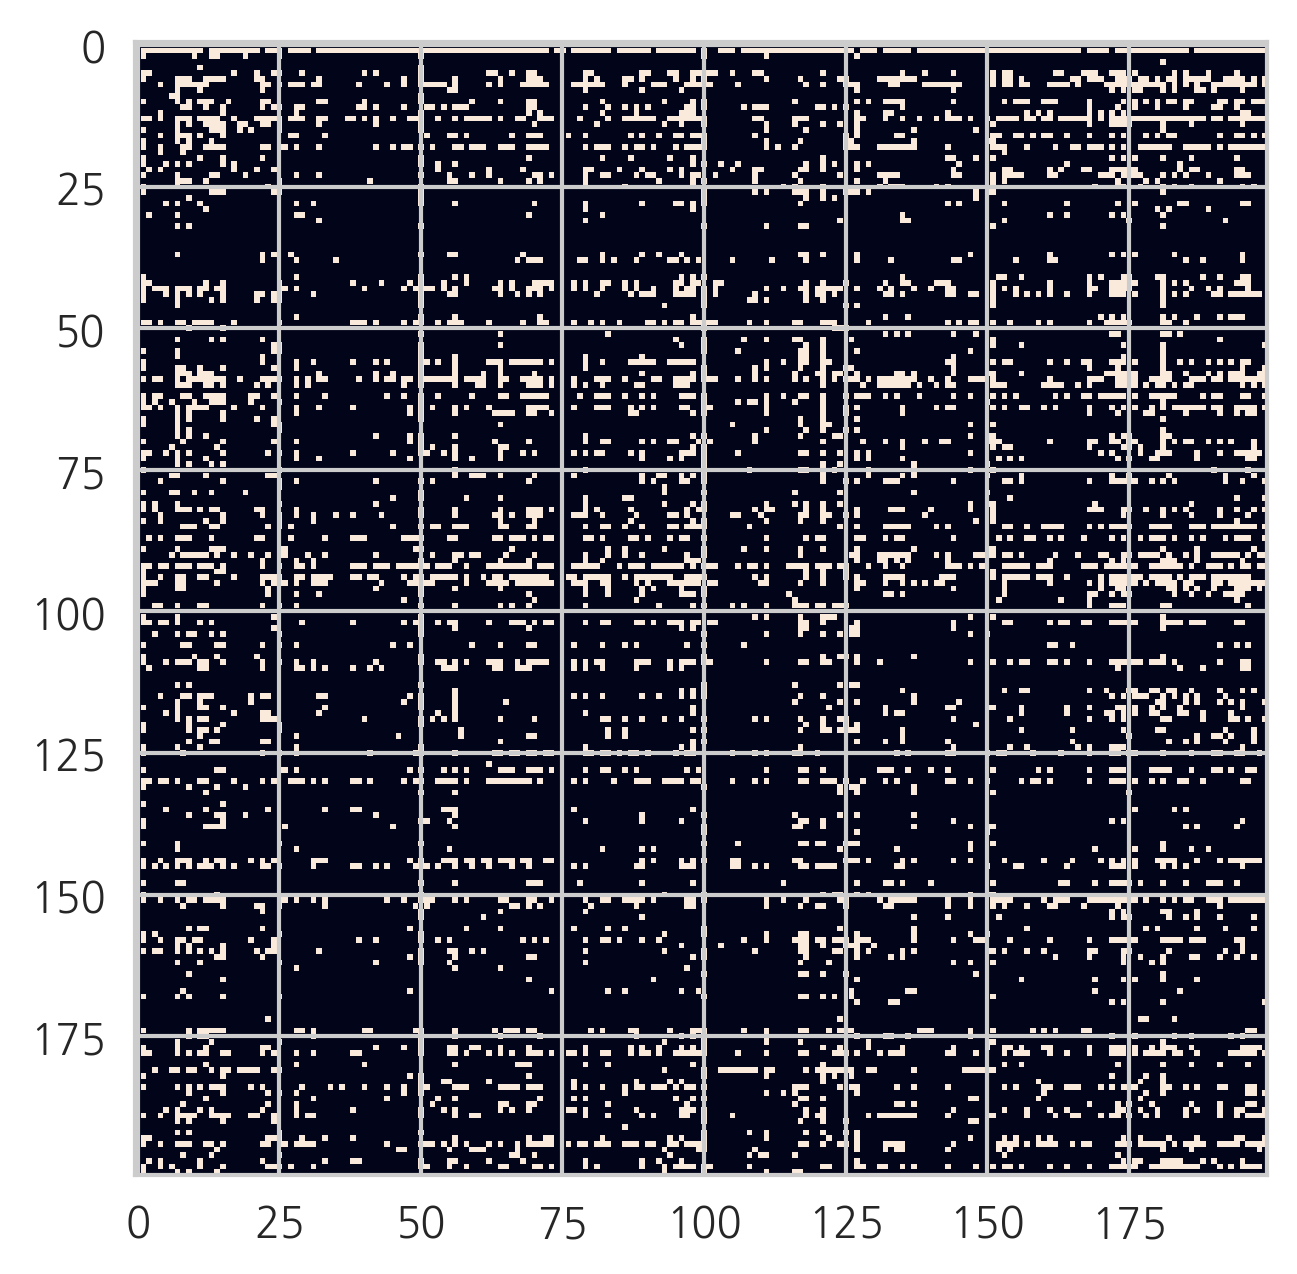

In [21]:
from matplotlib import pyplot as plt
norm = NormalizePositive(axis=1)
binary = (train > 0)
train = norm.fit_transform(train)
plt.imshow(binary[:200, :200], interpolation='nearest')

# P 203

In [24]:
from scipy.spatial import distance

dists = distance.pdist(binary, 'correlation')

dists = distance.squareform(dists)

In [23]:
neighbors = dists.argsort(axis=1)

filled = train.copy()
for u in range(filled.shape[0]):
    n_u = neighbors[u, 1:]
    
    for m in range(filled.shape[1]):
        revs = [train[neigh, m]
                   for neigh in n_u
                       if binary [neigh, m]]
        if len(revs):
            n = len(revs)
            n //= 2
            n += 1
            revs = revs[:n]
            filled[u, m] = np.mean(revs)

KeyboardInterrupt: 

In [ ]:
predicted = norm.inverse_transform(filled)

In [ ]:
filled.shape

In [ ]:
predicted.shape

In [ ]:
from sklearn import metrics
r2 = metrics.r2_score(test[test > 0], predicted[test > 0])
print(r2)

## A regression approach to recommendations

- An alternative to neighborhoods is to formulate recommendations as a regression priblem and apply the methods that we learned in the previous chapter.

- We also consider wht this problem is not a good fit for a classification formulation. We could certainly attempt to learn a five-class model, using one class for each possible movie rating. There are two problems with this approach.

- The different possible errors are not at all the same. For example, mistaking a 5-star movie for a 4-star one is not as serious a mistake as mistaking a 5-star movie for a 1-star one.

- Intermeidate values make sense. Even if out inputs are only integer values, it is perfectly meaningful to say that the prediction is 4.3. We can see that this is a different prediction that 3.5, even if they both round to 4.

In [37]:
from sklearn.linear_model import ElasticNetCV

regression = ElasticNetCV()

In [26]:
filled = train.copy()

In [30]:
def predict(train):
    binary = (train > 0)
    reg = ElasticNetCV(fit_intercept=True, alphas=[
                       0.0125, 0.025, 0.05, .125, .25, .5, 1., 2., 4.])
    norm = NormalizePositive()
    train = norm.fit_transform(train)

    filled = train.copy()
    # iterate over all users
    for u in range(train.shape[0]):
        # remove the current user for training
        curtrain = np.delete(train, u, axis=0)
        bu = binary[u]
        if np.sum(bu) > 5:
            reg.fit(curtrain[:,bu].T, train[u, bu])

            # Fill the values that were not there already
            filled[u, ~bu] = reg.predict(curtrain[:,~bu].T)
    return norm.inverse_transform(filled)

In [31]:
predict(train)

array([[ 0.        ,  0.40796283, -0.65306252, ..., -0.75848972,
         0.01294775, -0.37882156],
       [ 0.2036989 ,  1.0557044 ,  0.14518375, ..., -0.55479082,
         0.21664664, -0.17512266],
       [ 0.14105438,  0.29825809, -0.09544526, ..., -0.61743534,
         0.15400213, -0.23776718],
       ..., 
       [ 0.2804392 ,  1.05409255,  0.45557187, ..., -0.47805053,
         0.29338694, -0.09838237],
       [ 0.21946922,  0.83429584,  0.21454491, ..., -0.5390205 ,
         0.23241697, -0.15935234],
       [ 0.3156599 ,  0.83279234,  1.22356771, ..., -0.44282982,
         0.32860765, -0.06316166]])

## Combining multiple methods

- ensemble
- stacked learning

In [32]:
def get_train_test(reviews=None, random_state=None):
    '''Split data into training & testing

    Parameters
    ----------
    reviews : ndarray, optional
        Input data

    Returns
    -------
    train : ndarray
        training data
    test : ndarray
        testing data
    '''
    import numpy as np
    import random
    r = random.Random(random_state)

    if reviews is None:
        reviews = load()
    U,M = np.where(reviews)
    test_idxs = np.array(r.sample(range(len(U)), len(U)//10))
    train = reviews.copy()
    train[U[test_idxs], M[test_idxs]] = 0

    test = np.zeros_like(reviews)
    test[U[test_idxs], M[test_idxs]] = reviews[U[test_idxs], M[test_idxs]]

    return train, test

In [34]:
train, test = get_train_test(random_state=12)

In [35]:
tr_train, tr_test = get_train_test(random_state=34)

In [39]:
def predict(train):
    tr_train,tr_test = load_ml100k.get_train_test(train, random_state=34)
    tr_predicted0 = regression.predict(tr_train)
    tr_predicted1 = regression.predict(tr_train.T).T
    tr_predicted2 = corrneighbours.predict(tr_train)
    tr_predicted3 = corrneighbours.predict(tr_train.T).T
    tr_predicted4 = norm.predict(tr_train)
    tr_predicted5 = norm.predict(tr_train.T).T
    stack_tr = np.array([
        tr_predicted0[tr_test > 0],
        tr_predicted1[tr_test > 0],
        tr_predicted2[tr_test > 0],
        tr_predicted3[tr_test > 0],
        tr_predicted4[tr_test > 0],
        tr_predicted5[tr_test > 0],
        ]).T

    lr = linear_model.LinearRegression()
    lr.fit(stack_tr, tr_test[tr_test > 0])

    stack_te = np.array([
        tr_predicted0.ravel(),
        tr_predicted1.ravel(),
        tr_predicted2.ravel(),
        tr_predicted3.ravel(),
        tr_predicted4.ravel(),
        tr_predicted5.ravel(),
        ]).T

    return lr.predict(stack_te).reshape(train.shape)

## Basket analysis

### Obtaining usefull predictions

- more like about "customers who bought X, are statistically more likely to buy Y than the average suctomer who has not bought X"

### Analyzing supermarket shopping baskets

In [40]:
from collections import defaultdict
from itertools import chain

In [41]:
dataset = [[int(tok) for tok in line.strip().split()] for \
           line in open('retail.dat/retail.dat')]

In [42]:
dataset = [set(d) for d in dataset]

In [43]:
counts = defaultdict(int)
for elem in chain(*dataset):
    counts[elem] += 1

In [56]:
len(counts.keys())

16470

- There are many products that have only been bought a few times. For example, 33 percent of products were bought four or fewer times. However, this represents only 1 percent of purchases. This phenomenon that many products are only purchased a small number of times is sometimes labeled the long tail and has only become more prominent as the Internet made it cheaper to stock and sell niche  items. In order to be able to provide recommendations for these products, we would need a lot more data.

- Formally, the Apriori algorithm takes a collection of sets and returns sets that are very frequent as subsets

In [57]:
minsupport = 80

<img src="https://i-msdn.sec.s-msft.com/dynimg/IC702635.png">

In [58]:
valid = set(k for k, v in counts.items() if (v >= minsupport))

In [60]:
itemsets = [frozenset([v]) for v in valid]

- The frozenset type is immutable and hashable -- its contents cannot be altered after is created; however, it can be used as a dictionary key or as an element of another set.
- https://docs.python.org/2.4/lib/types-set.html

In [63]:
freqsets = []
for i in range(16):
    nextsets = []
    tested = set()
    for it in itemsets:
        for v in valid:
            if v not in it:
                # Create a new candidate set by adding v to it
                c = (it | frozenset([v]))
                
                # check If we have tested it already
                if c in tested:
                    continue
                tested.add(c)
                
                # Count support by looping over dataset
                # This step is slow.
                # Check 'apriori.py' for a better implementation.
                support_c = sum(1 for d in dataset if d.issuperset(c))
                if support_c > minsupport:
                    nextsets.append(c)

freqsets.extend(nextsets)
itemsets = nextsets

KeyboardInterrupt: 